In [1]:
# # !!! only uncomment and run when using colab !!!
# import os
# ! git clone https://github.com/Plant-Root-Soil-Interactions-Modelling/CPlantBox # downloading the source code
# os.chdir("/content/CPlantBox/")
# !apt install libeigen3-dev
# !pip3 install vtk
# ! git pull
# ! cmake .
# ! make
# os.chdir("/content/CPlantBox/tutorial/jupyter/crop_in_silico_2022/")

# Crop in silico - 2022 - water flow in CPlantBox

## Simulation of xylem water movement 


In the following we will show how to compute:

1. xylem water flux for a root segment for a pre-defined maximum transpiration 

2. xylem water flux and photosynthesis rate for a whole plant

We consider static root system and a static soil. 
To compute the water xylem flux we use the hybrid analytical approach of Meunier et al. (2017). Note that the model ist static (as most models are). To compute the photosynthesis rate, we use the Leuning methode, as presented by Tuzet et al. (2003).

**Reference**

F Meunier, X Draye, J Vanderborght, M Javaux, V Couvreur. A hybrid analytical-numerical method for solving water flow equations in root hydraulic architectures. *Applied Mathematical modelling*, 2017.

A Tuzet, A Perrier, R Leuning. A coupled model of stomatal conductance, photosynthesis and transpiration. *Plant, Cell & Environment*, 2003.

In [10]:
import sys; sys.path.append("../../.."); sys.path.append("../../../src")
import plantbox as pb
from functional.xylem_flux import XylemFluxPython  # Python hybrid solver
import numpy as np
import matplotlib.pyplot as plt
from functional.photosynthesis_cpp import PhotosynthesisPython

## 1. xylem flux in the root system

We present a minimal example with constant conductivities (based on *example6b_xylemflux.py*), where we give the soil water total potential per segment

In [2]:
""" root system """
simtime = 14  # [day] 
rs = pb.MappedRootSystem() # handles conductivity and mapping to the soil cells
path = "../../../modelparameter/structural/rootsystem/"
name = "Anagallis_femina_Leitner_2010"  # Zea_mays_1_Leitner_2010
rs.readParameters(path + name + ".xml")
random_parameters = rs.getRootRandomParameter()
for p in random_parameters[1:]:
    p.dx = 0.25 
rs.initialize() # note that an artificial root with type =0 is added in MappedRootSystem
rs.simulate(simtime)
# _ = vp.plot_roots(pb.SegmentAnalyser(rs.mappedSegments()), "subType") 

""" Parameters """
kz = 4.32e-2  # axial conductivity [cm^3/day]
kr = 1.728e-4  # radial conductivity [1/day]
p_top = -300  # top soil pressure [cm]
p0 = -500  # dirichlet bc at root collar [cm]
trans = -1.2  # neuman bc at root collar [cm3/day]

""" prepare soil matric potentials per segment"""
segs = rs.segments # MappedRootSystem has access to segments and nodes 
nodes = rs.nodes
p_s = np.zeros((len(segs),)) # soil total potentials around each root segment
for i, s in enumerate(segs):
    p_s[i] = p_top - 0.5 * (nodes[s.x].z + nodes[s.y].z)  # constant total potential (hydraulic equilibrium)

""" root problem """
r = XylemFluxPython(rs)
r.setKr([0., kr, kr , kr, kr, kr]) # no radial flux into the artificial root segment
r.setKx([1., kz, kz, kz, kz, kz])

""" Numerical solution """
#
# In the following 'cells = False' means total soil potentials 'p_s' is given for each segment
#

# rx = r.solve_neumann(simtime, trans, p_s, cells = False) # use Neumann bc 
# rx = r.solve_dirichlet(simtime, p0, 0, p_s, cells = False) # use Dirichlet bc
rx = r.solve(simtime, trans, 0, p_s, cells= False, wilting_point = -15000) # use Neumann, switch to Dirichlet if below wilting_point

fluxes1 = r.segFluxes(simtime, rx, p_s, cells = False)  # [cm3/day]
print("Transpiration", r.collar_flux(simtime, rx, [p_s], k_soil = [], cells = False), "cm3/day")


MappedRootSystem::initialize 
Transpiration -1.1999999999999695 cm3/day


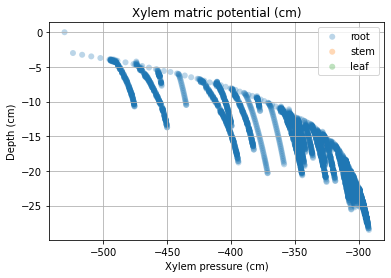

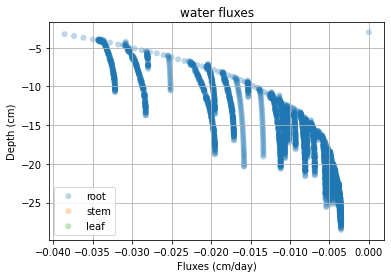

In [3]:

surfs = np.multiply(np.array(r.rs.segLength()), 2*np.array(r.rs.radii)*np.pi)  # root segment side surface [cm2]
fluxes = np.divide(fluxes1, surfs)  # we convert to [cm3/(cm2 day)]

""" plot results """
#vp.plot sometimes creates issues with pybinder but works with python
#ana = pb.SegmentAnalyser(r.rs)
#ana.addData("rx", rx) # add simulation result
# _ = vp.plot_roots(ana, "rx", "Xylem matric potential (cm)")  
#ana.addData("fluxes", fluxes) # add simulation result 
#_ = vp.plot_roots(ana, "fluxes", "Segment flux (cm/day)") 


fig, ax = plt.subplots()
name = ["root", "stem", "leaf"]
color = ['tab:blue', 'tab:orange', 'tab:green']
for ndType in [2, 3, 4]:
    #nodes = self.get_nodes()
    y = r.get_nodes_organ_type(ndType)#coordinates
    x = np.array(rx)[r.get_nodes_index(ndType)]
    ax.scatter(x, y[:,2], c=color[ndType-2],  label=name[ndType-2],
               alpha=0.3, edgecolors='none')

ax.legend()
ax.grid(True)
plt.xlabel("Xylem pressure (cm)")
plt.ylabel("Depth (cm)")
plt.title("Xylem matric potential (cm)")
plt.show()


fig, ax = plt.subplots()
name = ["root", "stem", "leaf"]
color = ['tab:blue', 'tab:orange', 'tab:green']
for ndType in [2, 3, 4]:
    segIdx = r.get_segments_index(ndType)
    nodesy = segIdx + np.ones(segIdx.shape, dtype = np.int64)
    nodes = r.get_nodes()
    y = np.array(nodes)[nodesy]#coordinates
    x = fluxes[segIdx]
    ax.scatter(x, y[:,2], c=color[ndType-2],  label=name[ndType-2],
               alpha=0.3, edgecolors='none')

ax.legend()
ax.grid(True)
plt.xlabel("Fluxes (cm/day)")
plt.ylabel("Depth (cm)")
plt.title("water fluxes")
plt.show()


## Take away messages

* Basic idea how to use the class *XylemFluxPython*
* How to set the root axial and radial conductivities in the class *MappedRootSystem*
* Look at the outputs of the xylem model

## 2. xylem flux in the whole plant

We present a minimal example with constant conductivities. 

In [11]:
simtime = 14  # [day] 
pl = pb.MappedPlant() #for plant objects
path = "../../../modelparameter/structural/plant/" 
name = "fspm2023" 
pl.readParameters(path + name + ".xml")

soilSpace = pb.SDF_PlantContainer(500,500, 500, True) #to avoid root growing aboveground
pl.setGeometry(soilSpace) # creates soil space to stop roots from growing out of the soil

pl.initialize()
pl.simulate(simtime)

#we give as input the initial guess of water potential and internal CO2 concentration
#for the fixed-point iteration
r = PhotosynthesisPython(pl, min(p_s), cs*0.7) #Equivalent to XylemFluxPython() for whole plant

We set the parameters:

In [46]:
kz = 4.32e-2  # axial conductivity [cm3/day]
kr_root = 1.728e-4  # radial conductivity [1/day]
kr_stem = 0  # radial conductivity of stem  [1/day], set to 0
kr_leaf =  0.004 #  radial conductivity of leaf xylem membrane [1/day] different from stomatal conductance
depth = 60 #cm
p_top = -1000  # top soil total potential [cm]
p_bot = p_top +depth # bot total potential [cm]

#envirenmental variables
RH = 0.5 # relative humidity [-]
TairC = 20 #air temperature [°C]
Q = 900e-6 #irradiance [mol quanta m-2 s-1]
cs = 350e-6 #co2 paartial pressure at leaf surface [mol mol-1]
es = 0.61078 * np.exp(17.27 * TairC / (TairC + 237.3))/10 # [hPa] #from FAO56
ea = es * RH


Rgaz=8.314 #J K-1 mol-1 = cm^3*MPa/K/mol
rho_h2o = 1 #g/cm3
Mh2o = 18.05 #g/mol
MPa2hPa = 10000
hPa2cm = 1.0197                     
p_a = np.log(RH)*Rgaz*rho_h2o*TairK/Mh2o *MPa2hPa*hPa2cm #air water potential [cm]

We give the total potential per soil voxel:

In [47]:
" Coupling to soil "
z_ = np.linspace(0,-depth,depth) # 0, -1, -2, ... -35

p_s = np.linspace(p_top, p_bot, depth)
soil_index = lambda x,y,z : max(int(np.floor(-z)),-1) #abovegroud nodes get index -1
pl.setSoilGrid(soil_index)


Create object to compute water flow:

In [48]:
""" Set up organ conductivities and atmospheric conditions"""

r.setKr([[kr_root],[kr_stem],[kr_leaf]]) #gmax will be changed by the leuning function 
r.setKx([[kz]])
r.airPressure = p_a 
r.Qlight = Q


Launche simulation:

In [50]:
#
# In the following 'cells = True' means total soil potentials 'p_s' is given for soil voxel
#
r.solve_photosynthesis(ea_=ea, es_ = es, sim_time_ = simtime, sxx_=p_s, cells_ = True, TairC_ = TairC)


Present outputs:

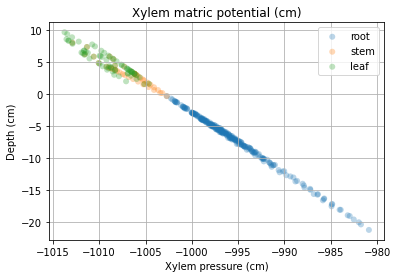

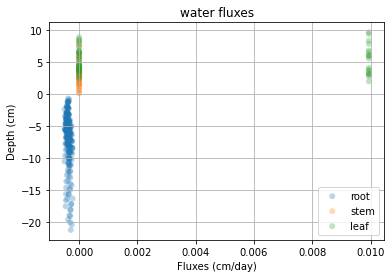

Transpiration 0.17892092338920587 cm3/day
Net assimilation 0.19196842791544025 mmol CO2 m-2 s-1


In [53]:
plantWatPot = r.psiXyl
fluxes = r.radial_fluxes(simtime, plantWatPot, p_s,[], True)  # cm3/day
surfs = np.multiply(np.array(r.rs.segLength()), 2*np.array(r.rs.radii)*np.pi)  # root segment side surface [cm2]
fluxes = np.divide(fluxes, surfs)  # we convert to [cm3/(cm2 day)]

""" plot results """
fig, ax = plt.subplots()
name = ["root", "stem", "leaf"]
color = ['tab:blue', 'tab:orange', 'tab:green']
for ndType in [2, 3, 4]:
    #nodes = self.get_nodes()
    y = r.get_nodes_organ_type(ndType)#coordinates
    x = np.array(plantWatPot)[r.get_nodes_index(ndType)]
    ax.scatter(x, y[:,2], c=color[ndType-2],  label=name[ndType-2],
               alpha=0.3, edgecolors='none')

ax.legend()
ax.grid(True)
plt.xlabel("Xylem pressure (cm)")
plt.ylabel("Depth (cm)")
plt.title("Xylem matric potential (cm)")
plt.show()


fig, ax = plt.subplots()
name = ["root", "stem", "leaf"]
color = ['tab:blue', 'tab:orange', 'tab:green']
for ndType in [2, 3, 4]:
    segIdx = r.get_segments_index(ndType)
    nodesy = segIdx + np.ones(segIdx.shape, dtype = np.int64)
    nodes = r.get_nodes()
    y = np.array(nodes)[nodesy]#coordinates
    x = fluxes[segIdx]
    ax.scatter(x, y[:,2], c=color[ndType-2],  label=name[ndType-2],
               alpha=0.3, edgecolors='none')

ax.legend()
ax.grid(True)
plt.xlabel("Fluxes (cm/day)")
plt.ylabel("Depth (cm)")
plt.title("water fluxes")
plt.show()


print("Transpiration", sum(fluxes[r.get_segments_index(4)]), "cm3/day")
print("Net assimilation", np.sum(r.An)*1e3, "mmol CO2 m-2 s-1")

## Take away messages

* Basic idea how to use the class *Leuning*
* How to set the root axial and radial conductivities in the class *MappedPlantSystem*
* How to use *MappedPlantSystem* to couple the segments to a soil grid
* Look at the outputs of the photosynthesis model
